# Ungraded Lab: GradCAM

This lab will walk you through generating gradient-weighted class activation maps (GradCAMs) for model predictions. 
- This is similar to the CAMs you generated before except:
  - GradCAMs uses gradients instead of the global average pooling weights to weight the activations.

## Imports

In [ ]:
%tensorflow_version 2.x

import warnings 
warnings.filterwarnings("ignore")

import os
import glob
import cv2
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread, imsave
from skimage.transform import resize 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import imgaug as ia
from imgaug import augmenters as iaa

## Download and Prepare the Dataset

You will use the Cats vs Dogs dataset again for this exercise. The following will prepare the train, test, and eval sets.

In [ ]:
tfds.disable_progress_bar()

splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

# load the dataset given the splits defined above
splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
num_examples

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteKZXVOQ/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


23262

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

# resizes the image and normalizes the pixel values
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return  image, label

# prepare batches
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = test_examples.map(format_image).batch(1)

## Modelling

You will use a pre-trained VGG16 network as your base model for the classifier. This will be followed by a global average pooling (GAP) and a 2-neuron Dense layer with softmax activation for the output. The earlier VGG blocks will be frozen and we will just fine-tune the final layers during training. These steps are shown in the utility function below.

In [ ]:
def build_model():
  # load the base VGG16 model
  base_model = vgg16.VGG16(input_shape=IMAGE_SIZE + (3,), 
                      weights='imagenet', 
                      include_top=False)
  
  # add a GAP layer
  output = layers.GlobalAveragePooling2D()(base_model.output)

  # output has two neurons for the 2 classes (cats and dogs)
  output = layers.Dense(2, activation='softmax')(output)

  # set the inputs and outputs of the model
  model = Model(base_model.input, output)

  # freeze the earlier layers
  for layer in base_model.layers[:-4]:
      layer.trainable=False

  # choose the optimizer
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  # configure the model for training
  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])
  
  # display the summary
  model.summary()
  
  return model

In [ ]:
model = build_model()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

You can now train the model. This will take around 10 minutes to run.

In [ ]:
EPOCHS = 3
model.fit(train_batches,
          epochs=EPOCHS,
          validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 152s 189ms/step - loss: 6.4872 - accuracy: 0.6903 - val_loss: 0.3892 - val_accuracy: 0.7962
Epoch 2/3
582/582 [==============================] - 104s 172ms/step - loss: 0.2093 - accuracy: 0.9277 - val_loss: 0.2454 - val_accuracy: 0.9127
Epoch 3/3
582/582 [==============================] - 104s 172ms/step - loss: 0.1553 - accuracy: 0.9473 - val_loss: 0.1236 - val_accuracy: 0.9506


## Model Interpretability

Let's now go through the steps to generate the class activation maps. You will start by specifying the layers you want to visualize.


In [ ]:
# select all the layers for which you want to visualize the outputs and store it in a list
outputs = [layer.output for layer in model.layers[1:18]]

# Define a new model that generates the above output
vis_model = Model(model.input, outputs)

# store the layer names we are interested in
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

    
print("Layers that will be used for visualization: ")
print(layer_names)

Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3']


### Class activation maps (GradCAM)

We'll define a few more functions to output the maps. `get_CAM()` is the function highlighted in the lectures and takes care of generating the heatmap of gradient weighted features. `show_random_sample()` takes care of plotting the results.

In [ ]:
def get_CAM(processed_image, actual_label, layer_name='block5_conv3'):
    model_grad = Model([model.inputs], 
                       [model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output_values, predictions = model_grad(processed_image)

        # watch the conv_output_values
        tape.watch(conv_output_values)

        ## Use binary cross entropy loss
        ## actual_label is 0 if cat, 1 if dog
        # get prediction probability of dog
        # If model does well, 
        # pred_prob should be close to 0 if cat, close to 1 if dog
        pred_prob = predictions[:,1] 
        
        # make sure actual_label is a float, like the rest of the loss calculation
        actual_label = tf.cast(actual_label, dtype=tf.float32)
        
        # add a tiny value to avoid log of 0
        smoothing = 0.00001 
        
        # Calculate loss as binary cross entropy
        loss = -1 * (actual_label * tf.math.log(pred_prob + smoothing) + (1 - actual_label) * tf.math.log(1 - pred_prob + smoothing))
        print(f"binary loss: {loss}")
    
    # get the gradient of the loss with respect to the outputs of the last conv layer
    grads_values = tape.gradient(loss, conv_output_values)
    grads_values = K.mean(grads_values, axis=(0,1,2))
    
    conv_output_values = np.squeeze(conv_output_values.numpy())
    grads_values = grads_values.numpy()
    
    # weight the convolution outputs with the computed gradients
    for i in range(512): 
        conv_output_values[:,:,i] *= grads_values[i]
    heatmap = np.mean(conv_output_values, axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()
    
    del model_grad, conv_output_values, grads_values, loss
   
    return heatmap

In [ ]:
def show_sample(idx=None):
    
    # if image index is specified, get that image
    if idx:
        for img, label in test_batches.take(idx):
            sample_image = img[0]
            sample_label = label[0]
    # otherwise if idx is not specified, get a random image
    else:
        for img, label in test_batches.shuffle(1000).take(1):
            sample_image = img[0]
            sample_label = label[0]
    
    sample_image_processed = np.expand_dims(sample_image, axis=0)
    
    activations = vis_model.predict(sample_image_processed)
    
    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]
    
    sample_activation = activations[0][0,:,:,16]
    
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    sample_activation *=255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)
    
    heatmap = get_CAM(sample_image_processed, sample_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    converted_img = sample_image.numpy()
    super_imposed_image = cv2.addWeighted(converted_img, 0.8, heatmap.astype('float32'), 2e-3, 0.0)

    f,ax = plt.subplots(2,2, figsize=(15,8))

    ax[0,0].imshow(sample_image)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
    
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.tight_layout()
    plt.show()
  
    return activations

### Time to visualize the results

binary loss: [-1.001353e-05]


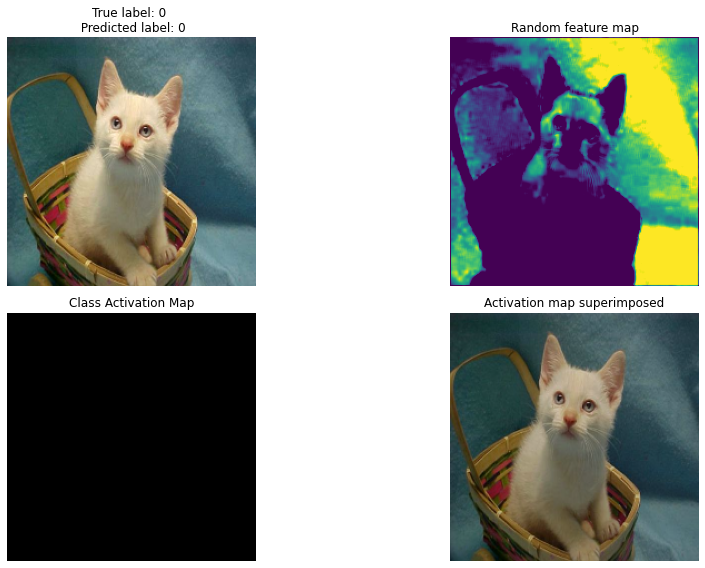

In [ ]:
# Choose an image index to show, or leave it as None to get a random image
activations = show_sample(idx=6)

### Intermediate activations of layers

You can use the utility function below to visualize the activations in the intermediate layers you defined earlier. This plots the feature side by side for each convolution layer starting from the earliest layer all the way to the final convolution layer.

In [ ]:
def visualize_intermediate_activations(layer_names, activations):
    assert len(layer_names)==len(activations), "Make sure layers and activation values match"
    images_per_row=16
    
    for layer_name, layer_activation in zip(layer_names, activations):
        nb_features = layer_activation.shape[-1]
        size= layer_activation.shape[1]

        nb_rows = nb_features // images_per_row
        grid = np.zeros((size*nb_rows, size*images_per_row))

        for row in range(nb_rows):
            for col in range(images_per_row):
                feature_map = layer_activation[0,:,:,row*images_per_row + col]
                feature_map -= feature_map.mean()
                feature_map /= feature_map.std()
                feature_map *=255
                feature_map = np.clip(feature_map, 0, 255).astype(np.uint8)

                grid[row*size:(row+1)*size, col*size:(col+1)*size] = feature_map

        scale = 1./size
        plt.figure(figsize=(scale*grid.shape[1], scale*grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(grid, aspect='auto', cmap='viridis')
    plt.show()

In [ ]:
visualize_intermediate_activations(activations=activations, 
                                   layer_names=layer_names)

Output hidden; open in https://colab.research.google.com to view.

If you scroll all the way down to see the outputs of the final conv layer, you'll see that there are very few active features and these are mostly located in the face of the cat. This is the region of the image that your model looks at when determining the class.